## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-06-16 21:44:38.964 | INFO     |  Running on cpu


In [3]:
#task = 'TurnOnLight'
serie = 'demos'
task = 'MoveToCabinetRight'
path = data_root / task / serie

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))


2025-06-16 21:44:43.112 | INFO     |  Loading dataset(s): 
2025-06-16 21:44:43.113 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/MoveToCabinetRight/demos/metadata.json
2025-06-16 21:44:43.114 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-06-16 21:44:43.114 | INFO     |    Extracted tsdf object labels []
2025-06-16 21:44:43.114 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dt

In [4]:
gt_pose_config = {
    #'indeces': [1,2,3,4],
}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'front',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([70, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([70]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([70, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([70, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([70, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([70, 3, 256, 256]), device=cpu, dtype=to

In [6]:
tag="release"

tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,  # Use rotation aswell?
    add_gripper_action=True,
    heal_time_variance=False,
    reg_shrink=1e-2, # 1e-2 is 0.01
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,

    em_steps=50,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.75,
    use_bic=False, #Does prune segmentation
    drop_redundant_frames=True,

)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    velocity_threshold=0.001,
    components_prop_to_len=True,
    min_end_distance=10,
)

cascade_config = CascadeConfig()

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-06-16 21:44:46.230 | INFO     |  Fitting AutoTPGMM
2025-06-16 21:44:46.230 | INFO     |  Performing fitting actions: [INIT]
2025-06-16 21:44:46.230 | INFO     |  Segmenting trajectories


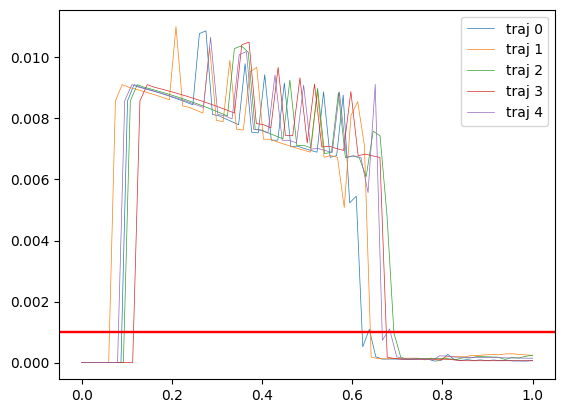

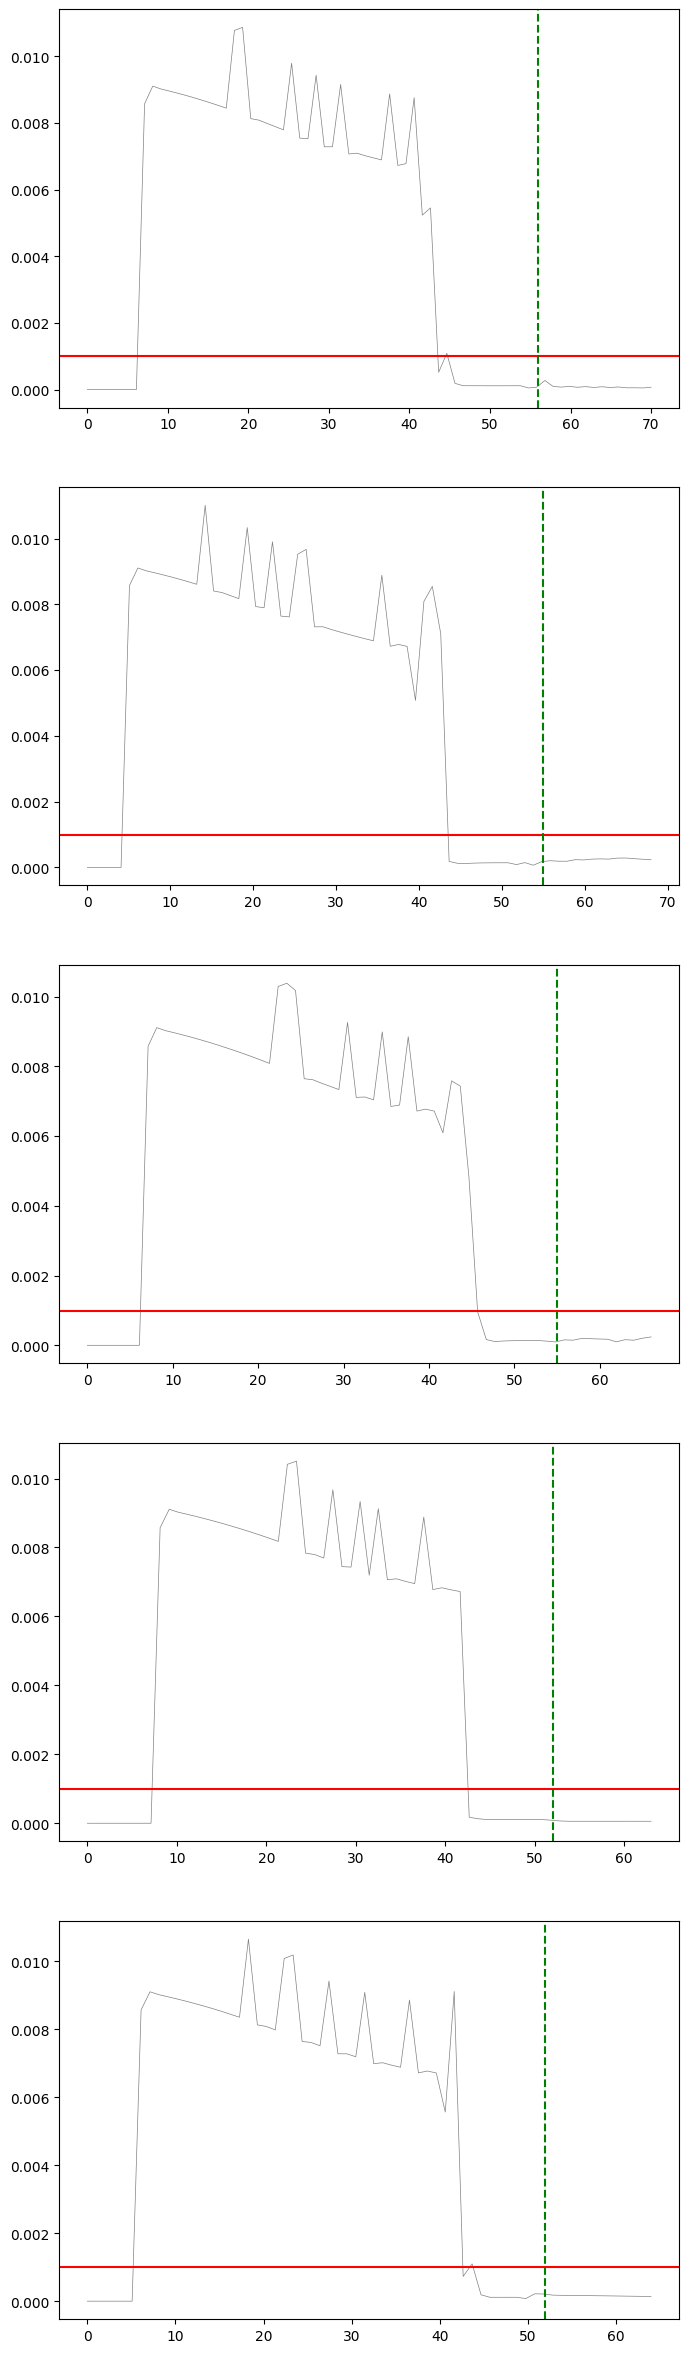

2025-06-16 21:44:47.035 | INFO     |  Creating segement of demos.
2025-06-16 21:44:47.045 | INFO     |  Subsampling to length 63 using strategy mean-length.
2025-06-16 21:44:47.046 | INFO     |  Creating segement of demos.
2025-06-16 21:44:47.053 | INFO     |  Subsampling to length 21 using strategy mean-length.
2025-06-16 21:44:47.054 | INFO     |  ... created 2 segments
2025-06-16 21:44:47.054 | INFO     |    Fitting candidate frame 1/10
2025-06-16 21:44:47.054 | INFO     |    Creating partial frame view of demos.
2025-06-16 21:44:47.060 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-06-16 21:44:47.060 | INFO     |    Changing number of components to 6
2025-06-16 21:44:47.060 | INFO     |    Init strategy not specified. Auto selected InitStrategy.TIME_BASED.
2025-06-16 21:44:47.060 | INFO     |    Model init ...


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:47.324 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:44:47.324 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:47.622 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:44:47.622 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:48.009 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:44:48.009 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:48.322 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:44:48.323 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:48.661 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:44:48.661 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:48.980 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:44:48.980 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:49.389 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:44:49.392 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:49.833 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:44:49.834 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:50.300 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:44:50.300 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:50.744 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-06-16 21:44:50.744 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-06-16 21:44:50.744 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-06-16 21:44:50.744 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-06-16 21:44:50.744 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-06-16 21:44:50.744 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-06-16 21:44:50.744 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-06-16 21:44:50.744 | INFO     |  obj006     score (rel):     -0 (0.000)
2025-06-16 21:44:50.744 | INFO     |  obj007     score (rel):     -0 (0.000)
2025-06-16 21:44:50.745 | INFO     |  obj008     score (rel):     -0 (0.000)
2025-06-16 21:44:50.745 | INFO     |  Dropping redundant frames [2 3 4 5 6].
2025-06-16 21:44:50.746 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:44:50.748 | INFO     |    Fitting candidate frame 1/10
2025-06-

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:50.839 | INFO     |    Fitting candidate frame 2/10
2025-06-16 21:44:50.840 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:50.936 | INFO     |    Fitting candidate frame 3/10
2025-06-16 21:44:50.936 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.033 | INFO     |    Fitting candidate frame 4/10
2025-06-16 21:44:51.033 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.133 | INFO     |    Fitting candidate frame 5/10
2025-06-16 21:44:51.133 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.227 | INFO     |    Fitting candidate frame 6/10
2025-06-16 21:44:51.228 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.361 | INFO     |    Fitting candidate frame 7/10
2025-06-16 21:44:51.362 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.470 | INFO     |    Fitting candidate frame 8/10
2025-06-16 21:44:51.471 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.632 | INFO     |    Fitting candidate frame 9/10
2025-06-16 21:44:51.632 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.772 | INFO     |    Fitting candidate frame 10/10
2025-06-16 21:44:51.772 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-06-16 21:44:51.903 | INFO     |  Dropping redundant frames [1 2 3 4 5 6].
2025-06-16 21:44:51.904 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:44:51.906 | INFO     |  Segmented trajs into 2 segments
2025-06-16 21:44:51.948 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142900 -0.142908 -0.142908 -0.142908 -0.142908 -0.142908   
Segment 1 -0.142896 -0.142851 -0.142851 -0.142851 -0.142851 -0.142851   

             obj005        obj006        obj007        obj008  
Segment 0 -0.142908 -6.501027e-09 -4.005865e-09 -1.466288e-08  
Segment 1 -0.142851 -7.015150e-09 -3.973684e-09 -1.607173e-08  
2025-06-16 21:44:51.952 | INFO     |  Frame score (rel):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0  0.999948  1.000000  1.000000  1.000000  1.000000  1.000000   
Segment 1  1.000000  0.999679  0.999679  0.999679  0.999679  0.999679   

             obj005        ob

Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:44:51.984 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R1


Time-based init:   0%|          | 0/6 [00:00<?, ?it/s]

2025-06-16 21:44:52.507 | INFO     |  Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[3.79e+023, 3.79e+023, 9.76e+022, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [6.78e+020, 2.56e+021, 7.25e+021, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [1.40e+012, 2.79e+013, 3.56e+014, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [2.73e+005, 3.74e+006, 3.59e+007, ..., 0.00e+000, 0.00e+000,
          0.00e+000],
         [3.80e-146, 6.76e-145, 1.12e-143, ..., 9.23e+013, 3.40e+013,
          1.14e+013],
         [2.14e-215, 4.65e-213, 9.35e-211, ..., 1.87e+020, 1.34e+020,
          8.62e+019]]),
  array([[3.54e+12, 3.45e+12, 1.49e+12, 2.86e+11, 2.45e+10, 8.93e+08,
          1.52e+07, 1.15e+05, 3.90e+02, 5.88e-01, 3.96e-04, 1.19e-07,
          1.59e-11, 1.02e-15, 2.95e-20, 3.81e-25, 2.20e-30, 5.68e-36,
          6.57e-42, 3.40e-48, 7.88e-55, 5.64e+12, 5.64e+12, 2.51e+12,
          5.00e+11, 4.47e+10, 1.78e+09, 3.17e+07, 2.52e+05, 8.99e+02,
          1.44e+00, 1.02e-03, 3.21e-07, 4.63e-11, 3.00e-15, 8.67e-20,
          1.12e-24, 6.51e-

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.INIT,))


2025-06-16 21:44:52.744 | INFO     |  Did not specify time_based, deciding automatically.
2025-06-16 21:44:53.073 | WARNING  |  Skippig NaN Gaussians.


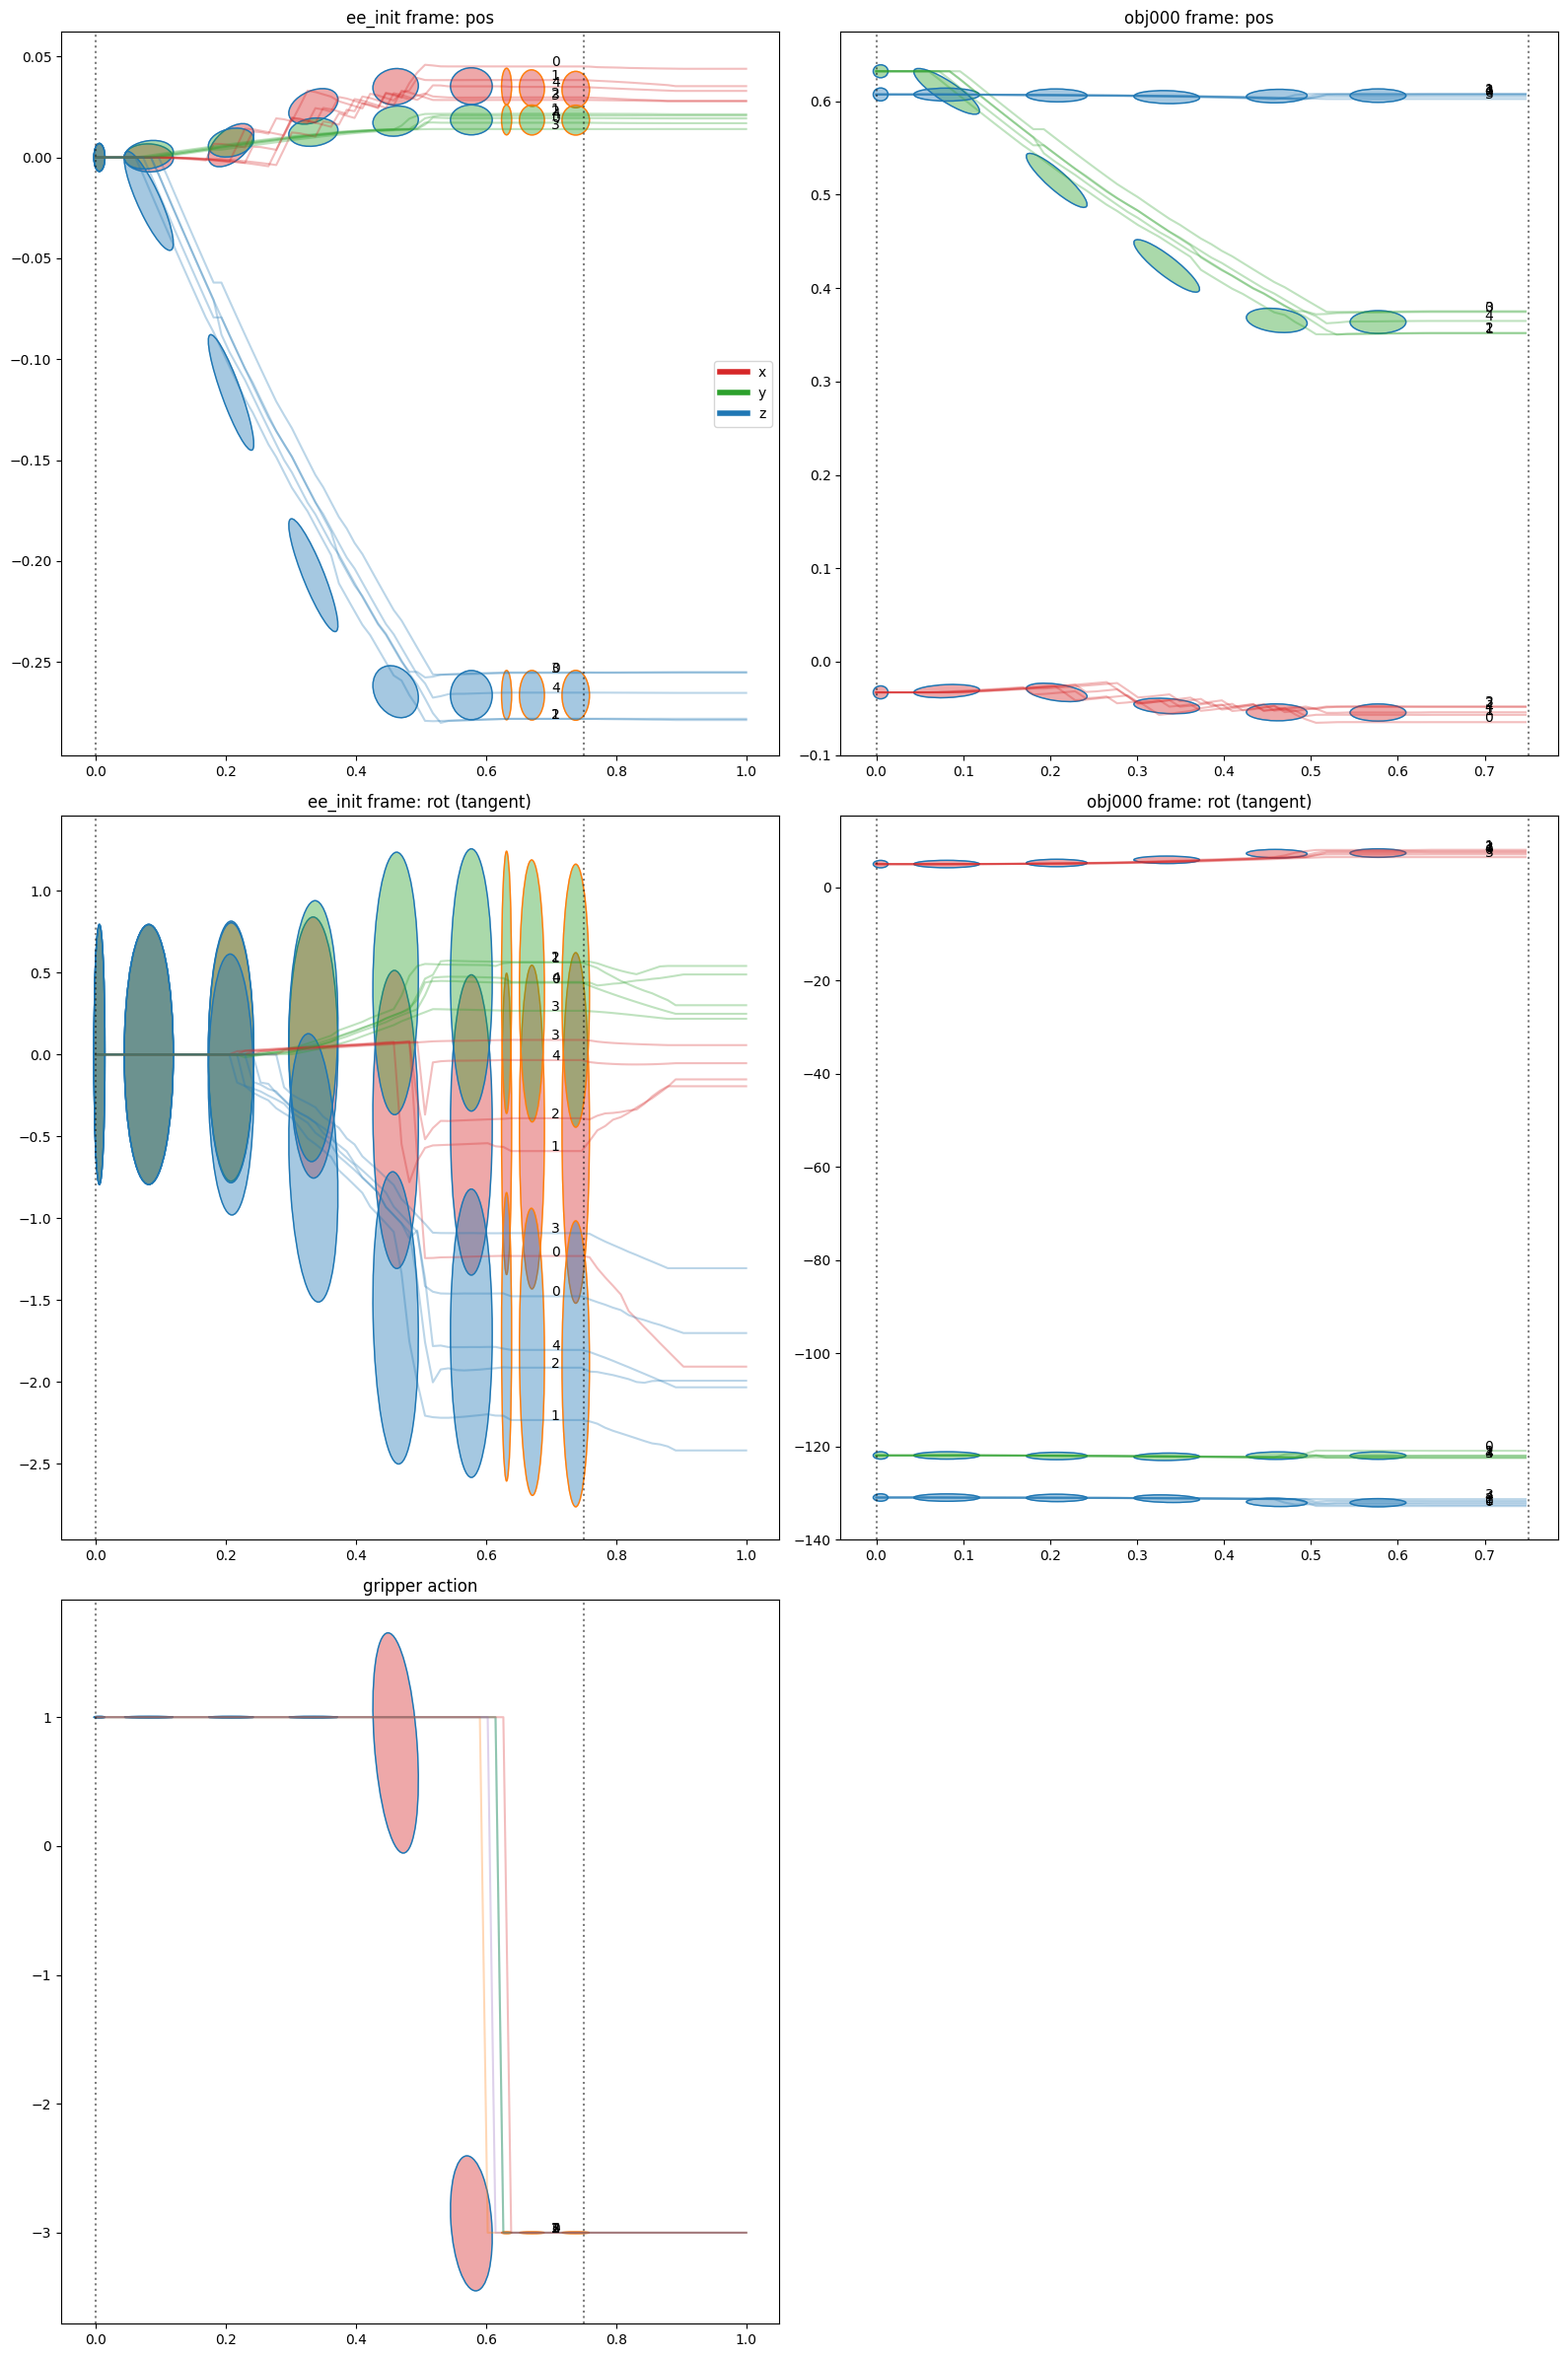

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-06-16 21:44:55.448 | INFO     |  Fitting AutoTPGMM
2025-06-16 21:44:55.448 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/2 [00:00<?, ?it/s]

2025-06-16 21:44:55.461 | INFO     |  HMM EM ...
2025-06-16 21:44:55.473 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-06-16 21:44:55.561 | INFO     |  HMM init priors not defined, initializing to uniform
2025-06-16 21:45:17.267 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.00e+00, 1.00e+00, 1.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 3.59e-24, 2.73e-16, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 3.30e-89, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 0.00e+00, 0.00e+00, 0.00e+00],
         [0.00e+00, 0.00e+00, 0.00e+00, ..., 1.00e+00, 1.00e+00, 1.00e+00]]),
  array([[1.00e+000, 1.00e+000, 1.00e+000, 9.94e-001, 6.91e-001, 2.27e-002,
          4.80e-006, 2.79e-012, 2.14e-021, 1.07e-033, 1.71e-049, 4.43e-069,
          9.02e-093, 7.59e-121, 1.32e-153, 2.34e-191, 2.14e-234, 4.99e-283,
          0.00e+000, 0.00e+000, 0.00e+000, 1.00e+000, 1.00e+000, 1.00e+000,
          9.97e-001, 7.51e-001, 3.22e-002, 8.83e-006, 6.74e-012, 6.90e-021,
          4.69e-033, 1.05e-048, 3.84e-068, 1.17e-091, 1.48e-119, 3.87e-152,
          1.05e-189, 1.46e-232, 5.21e-281, 0.00e+000, 0.00e+000, 0.00e+000,
          

2025-06-16 21:45:17.979 | INFO     |  Did not specify time_based, deciding automatically.


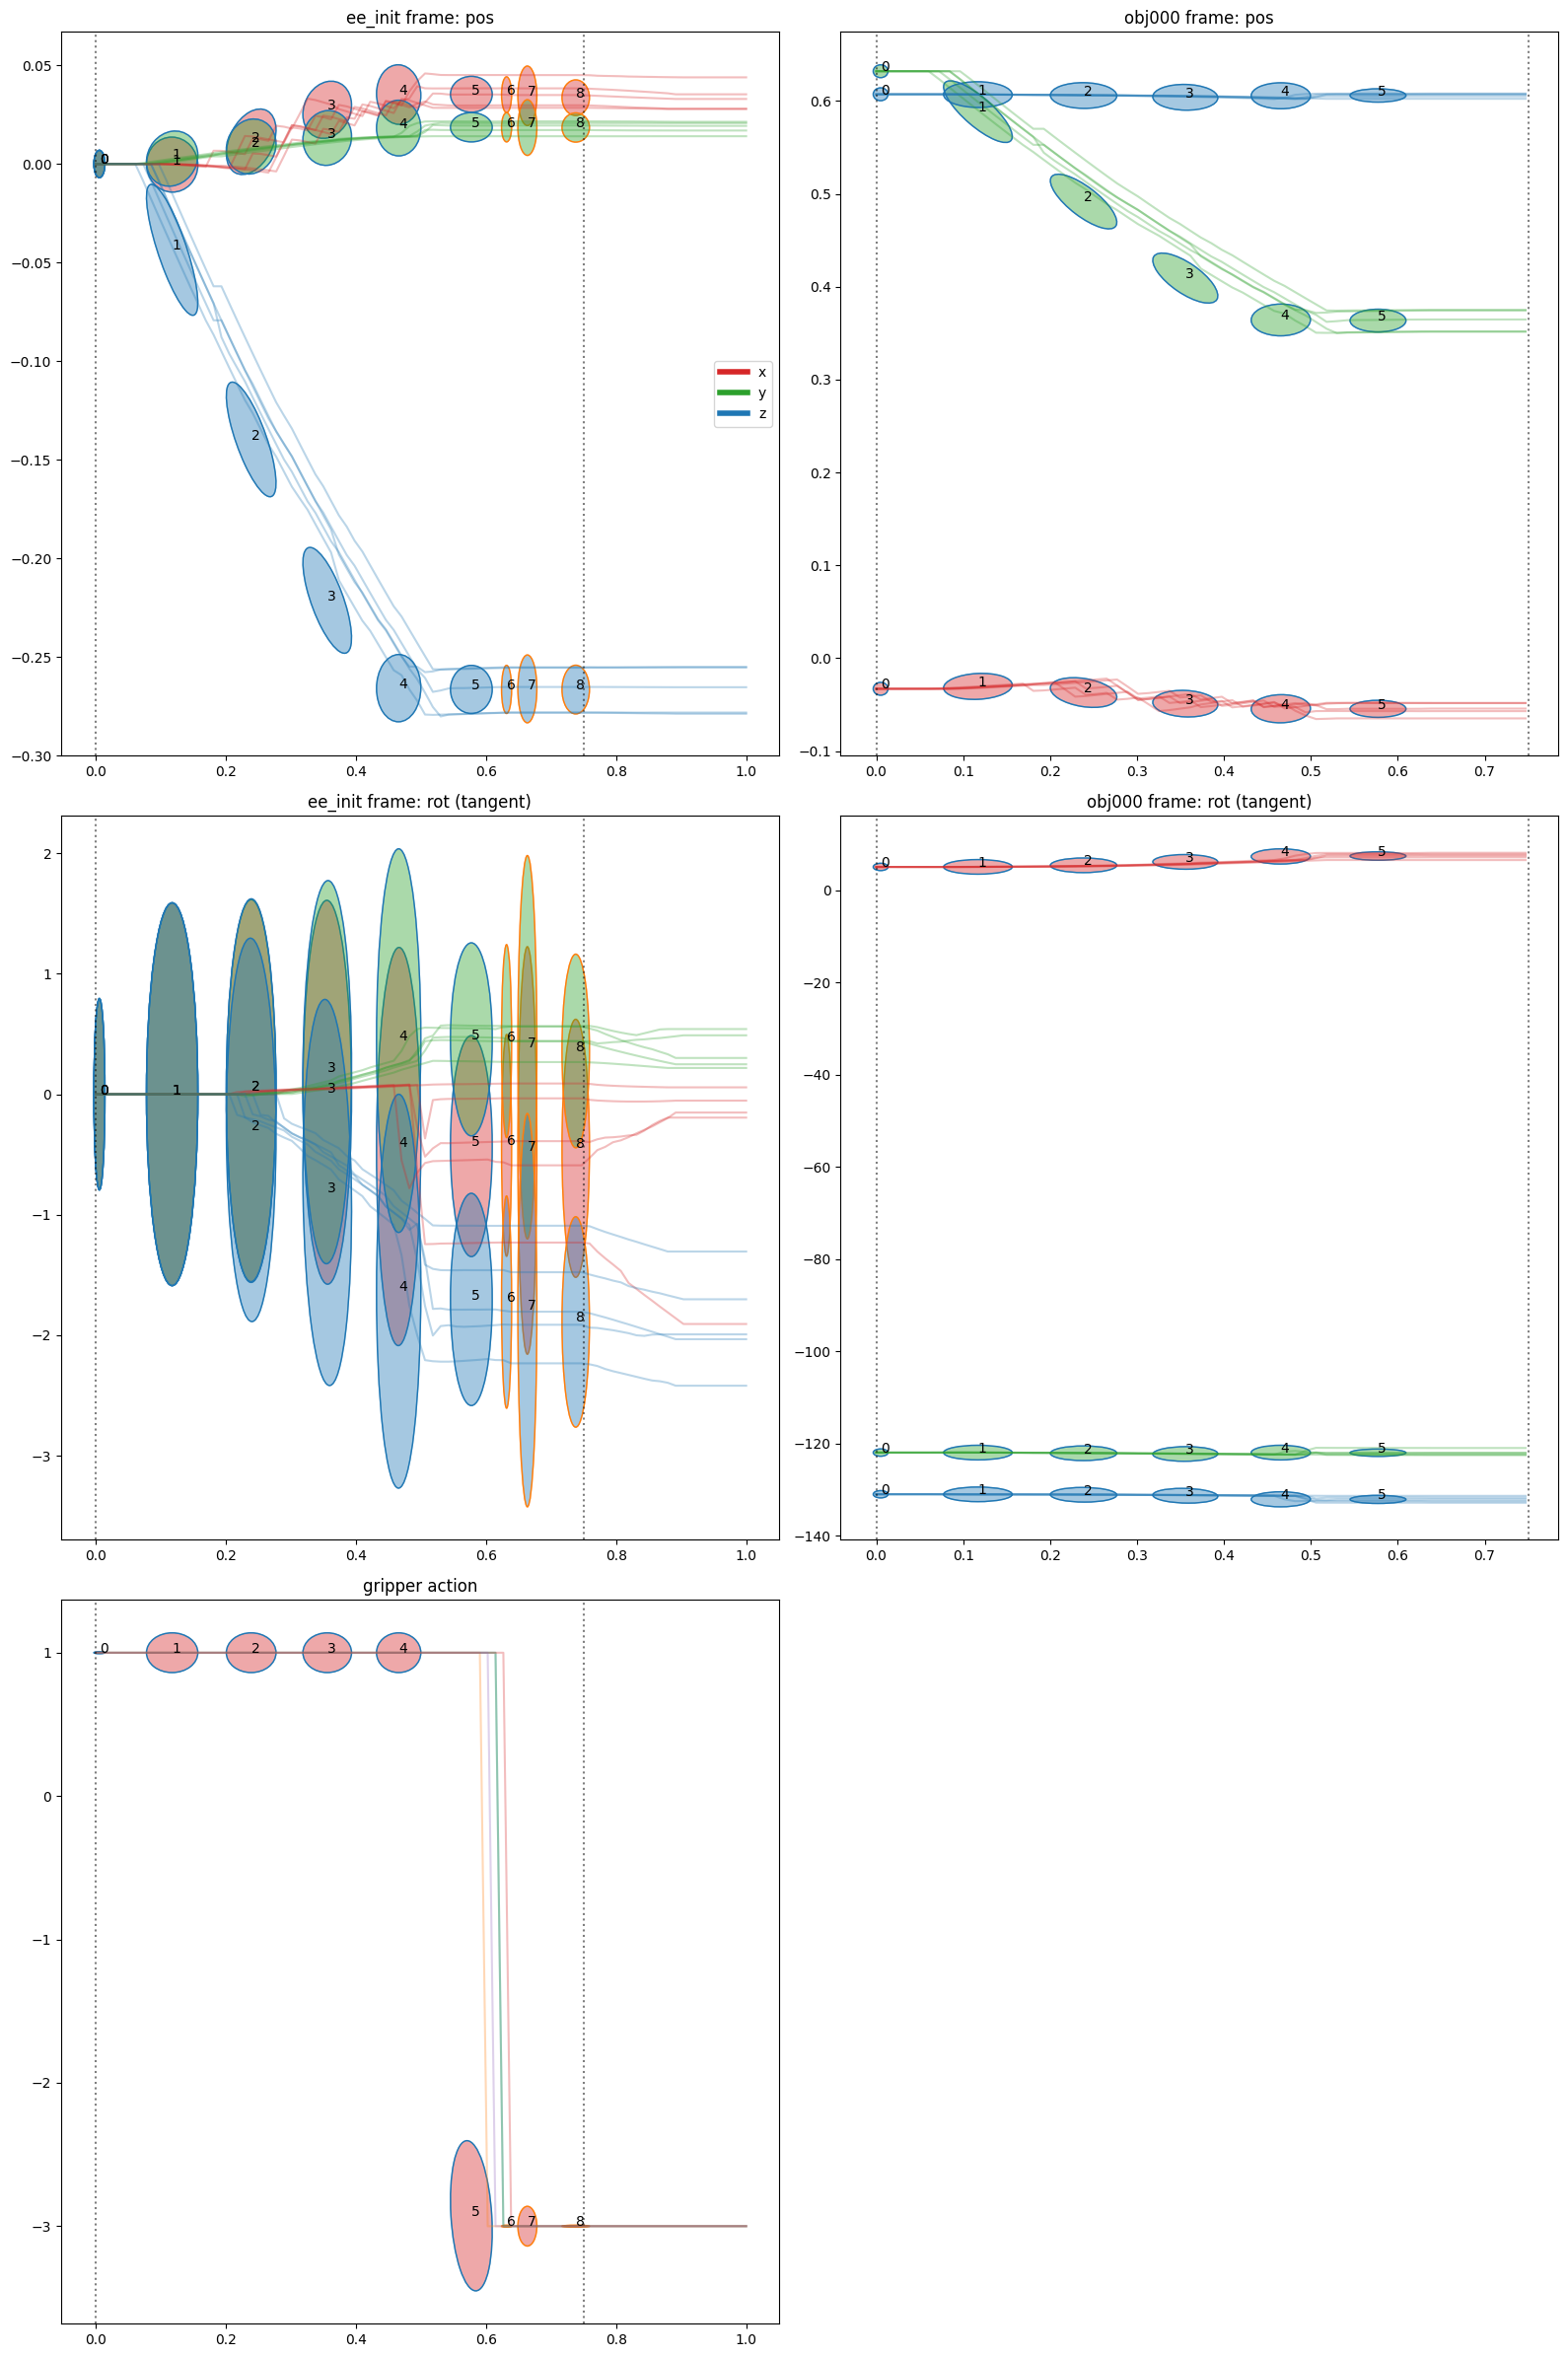

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

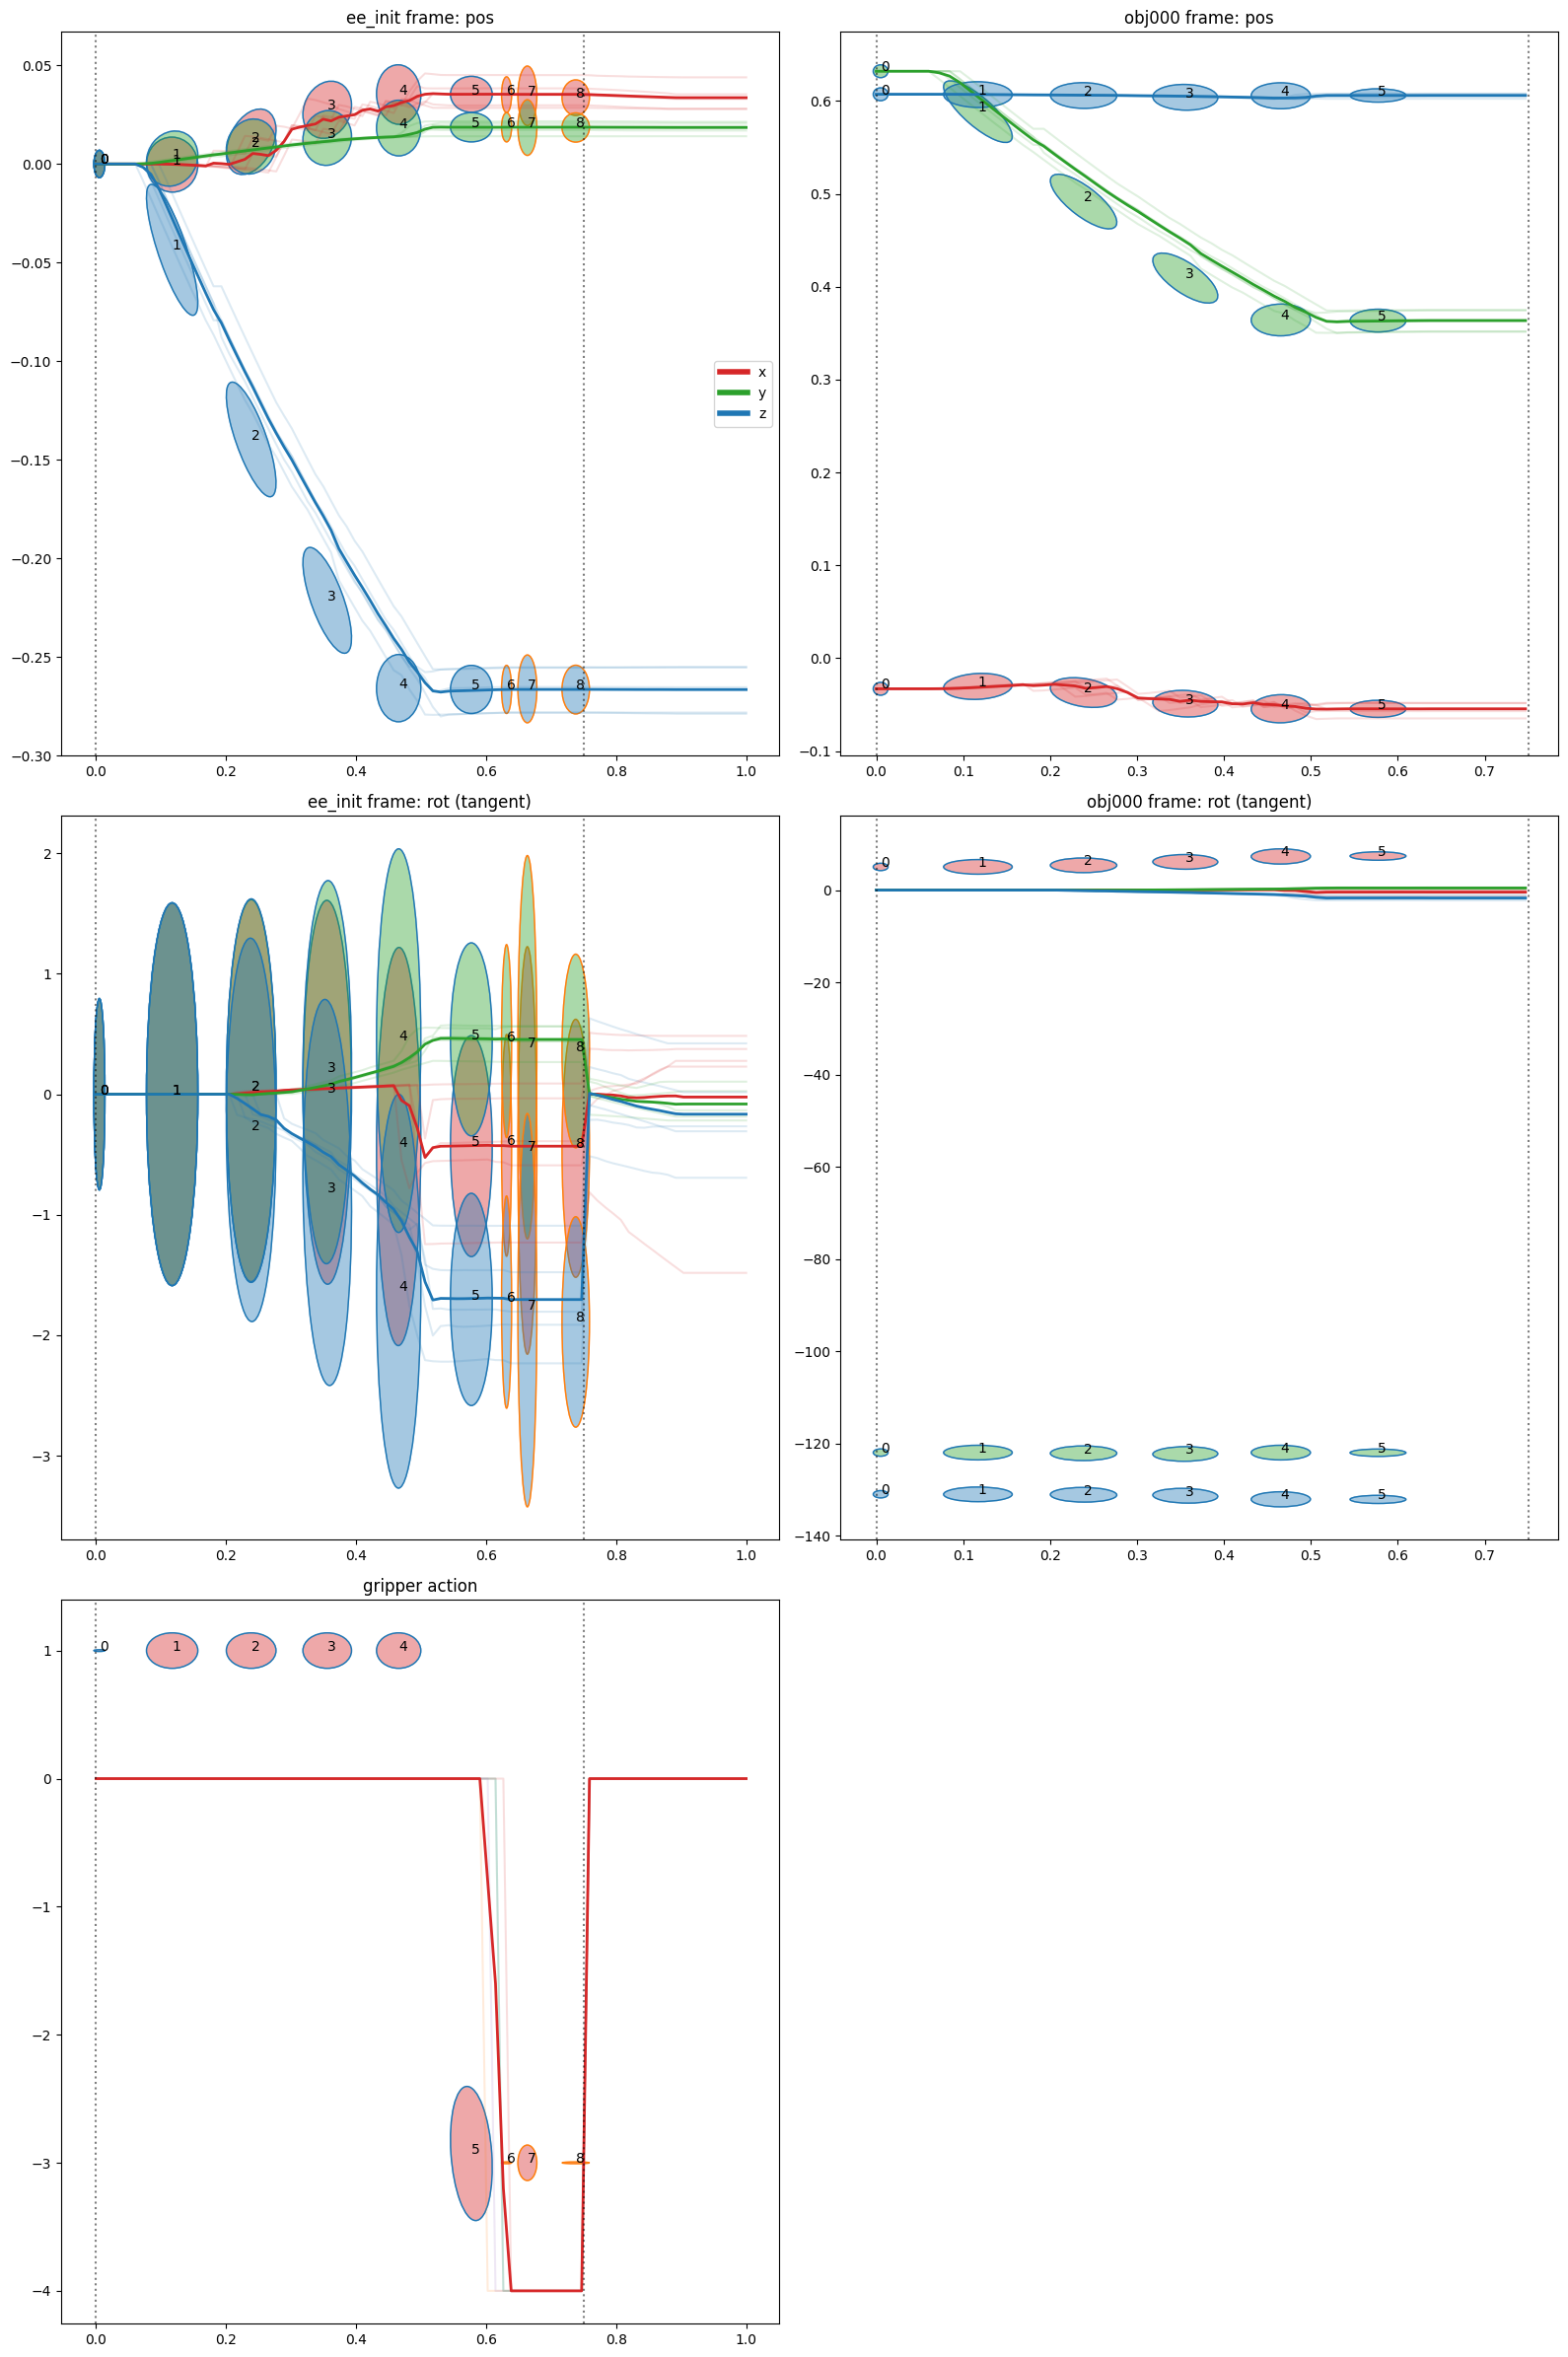

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=True, per_segment=False, gaussian_mean_only=False, plot_traj_means=True, time_based=True)

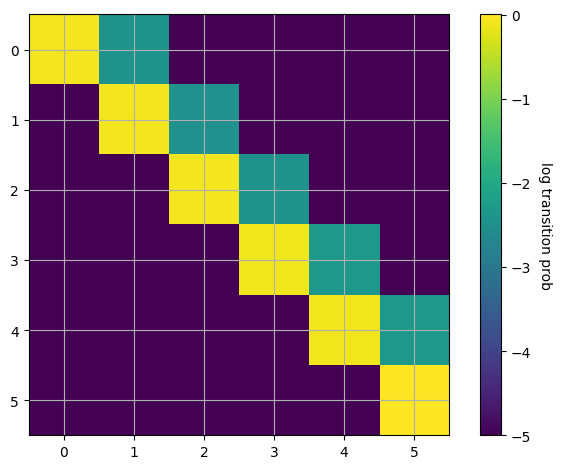

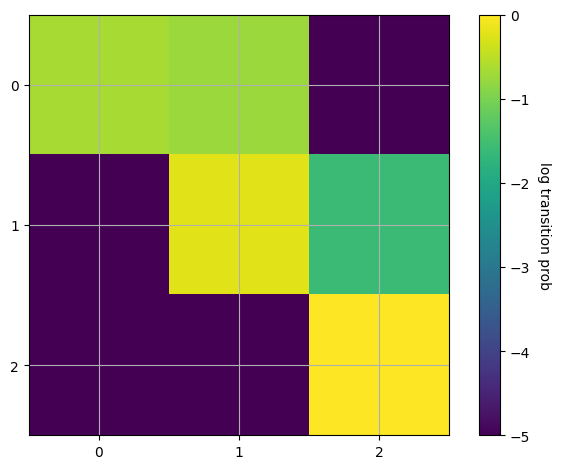

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / f'{serie}_gmm_policy-{tag}.pt')

2025-06-16 21:45:23.623 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-06-16 21:45:23.833 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-06-16 21:45:38.239 | INFO     |  Caculated segment transition probabilities: (array([[8.63e-14]]),)
2025-06-16 21:45:38.240 | WARNING  |  At least one segment transition prob below 5%. Can lead to problems.Consider increasing the diag reg.
2025-06-16 21:45:38.240 | INFO     |  Creating partial frame view of demos.
2025-06-16 21:45:38.243 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 21:45:38.403 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-16 21:45:38.458 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

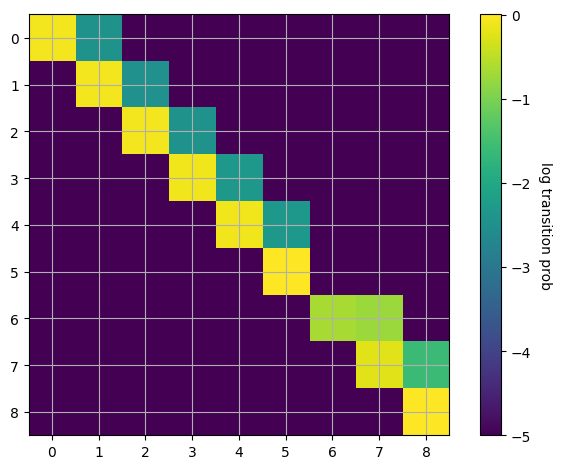

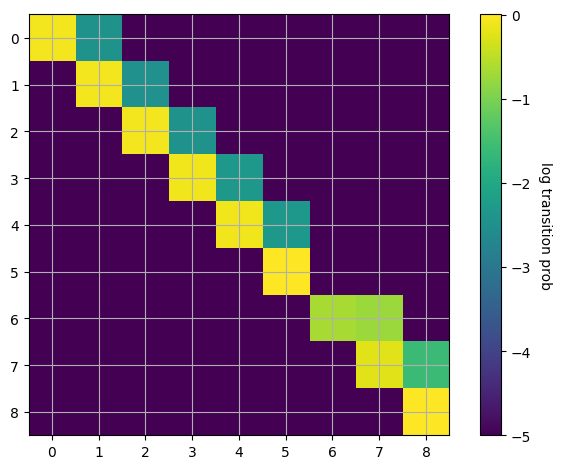

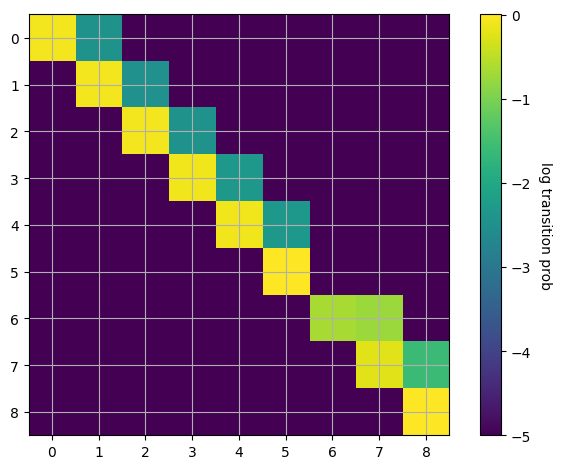

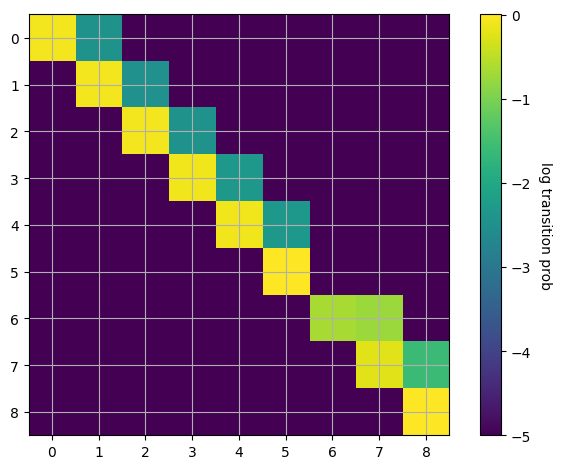

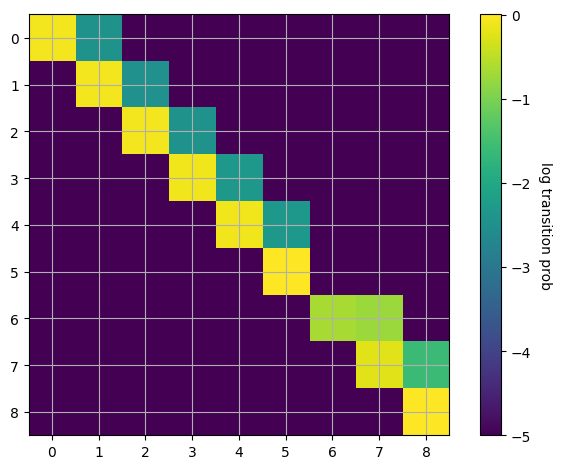

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-06-16 21:45:44.595 | INFO     |  Taking frame origins from demos.


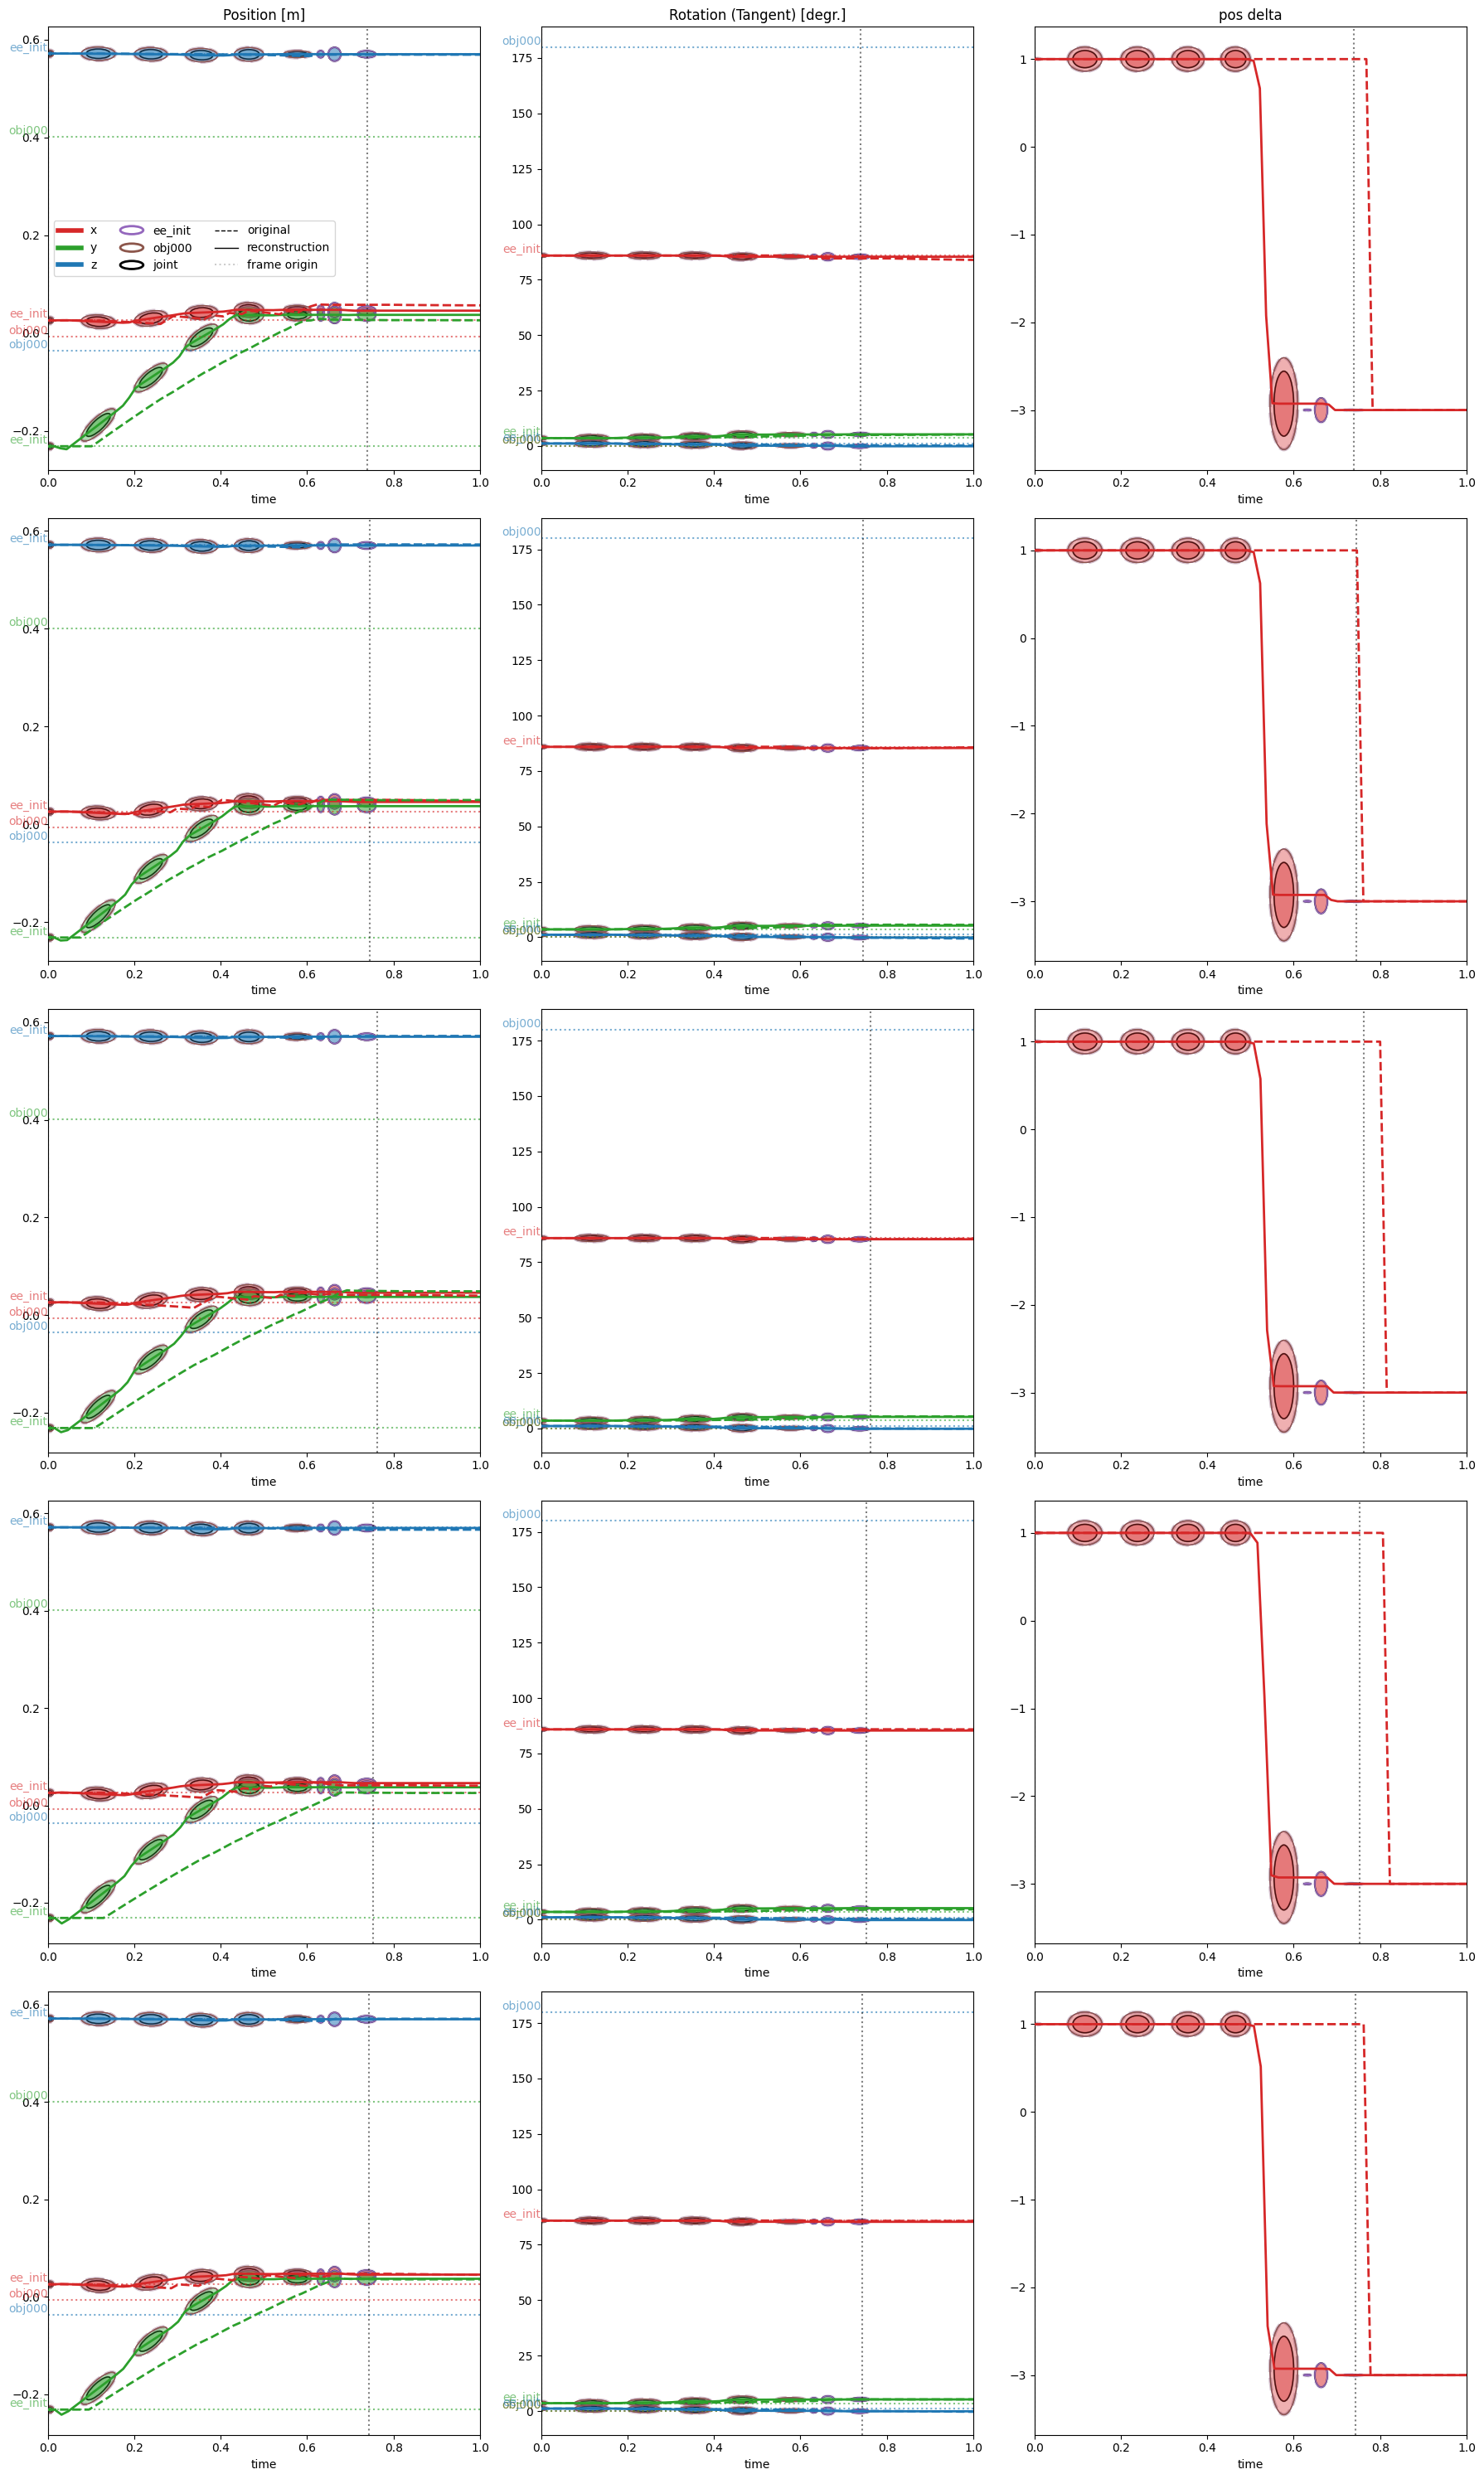

In [17]:
atpgmm.plot_reconstructions(
    seg_trans_marg_container,
    cascaded_hmms,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=False,
    per_segment=False,
)

In [18]:
atpgmm.plot_reconstructions(
    seg_trans_marginals,
    seg_joint_models,
    reconstructions,
    original_trajectories,
    plot_trajectories=True,
    plot_reconstructions=True,
    plot_gaussians=True,
    time_based=True,
    equal_aspect=True,
    per_segment=False,
)

2025-06-16 21:45:55.707 | INFO     |  Taking frame origins from demos.


AttributeError: 'tuple' object has no attribute 'np_to_manifold_to_np'